# Learning with Jointly with Reinforcement Learning and Supervised Learning 

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d


# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE

from utils.plotting import plot_trained_trajectories

### Train RNN on four targets using RFLO

In [3]:
trial_duration = 20
n_in=4
frac_on = 0.5

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

## 1. Train W_fb with REINFORCE on VMR Task

The VMR task is straightforward and should be easily learned by training the feedback weights only.

In [10]:
theta = np.pi/8
R = np.ones((2,2))
R[0,0]=np.cos(theta)
R[0,1]=-np.sin(theta)
R[1,0]=np.sin(theta)
R[1,1]=np.cos(theta)
task1r = Task(x_in=x_pulse1, y_target = R @ np.asarray([[1],[1]]))
task2r = Task(x_in=x_pulse2, y_target = R @ np.asarray([[-1],[1]]))
task3r = Task(x_in=x_pulse3, y_target = R @ np.asarray([[1],[-1]]))
task4r = Task(x_in=x_pulse4, y_target = R @ np.asarray([[-1],[-1]]))

30it [00:00, 294.43it/s]

apply_to :  ['w_rec', 'w_out']
online :  True
weight_transport :  True


500it [00:01, 379.78it/s]
5000it [00:25, 192.98it/s]


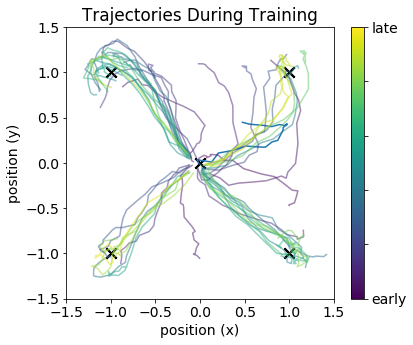

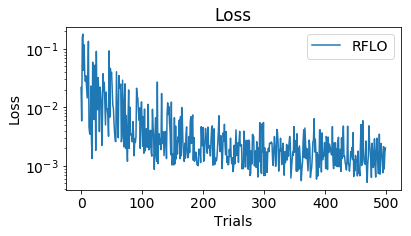

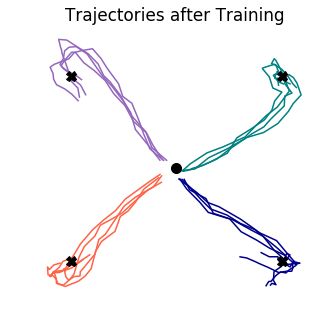

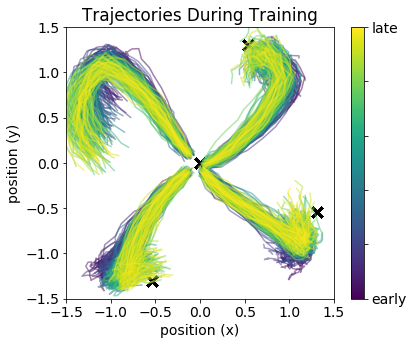

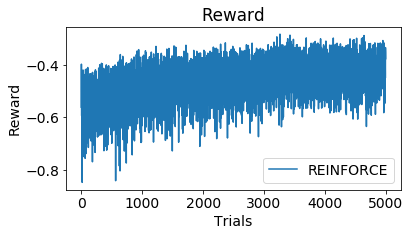

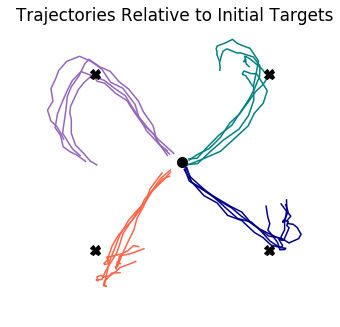

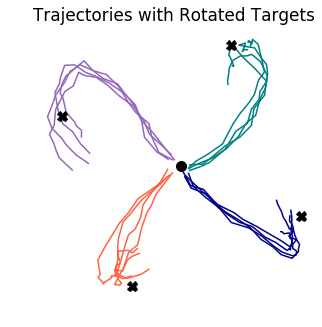

In [19]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.1,
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False,
               driving_feedback=True,
               rng=np.random.RandomState(1))

# Initialize RNN
net = RNN(params)

# set feedback weights to be the same as the transpose of w_out
net.set_weights(w_fb=np.copy(net.w_m))


# initialize simulation
sim = Simulation(net)

rflo = RFLO(net,apply_to=['w_rec','w_out'])
rflo.print_params()
sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=[], plot=True, plot_freq=10)

fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])

#rflo = RFLO(net,apply_to=['w_fb']) 
#rflo.print_params()
reinforce = REINFORCE(net,apply_to=['w_fb'],online=False,tau_reward=5)

sim.run_session(n_trials=5000, tasks=[task1r,task2r,task3r,task4r], learn_alg=[reinforce], probe_types=['h','y_out','pos'], plot=True, plot_freq=5)

fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='Trajectories Relative to Initial Targets')
fig = plot_trained_trajectories(sim=sim, tasks=[task1r,task2r,task3r,task4r],title='Trajectories with Rotated Targets')




In [20]:
params.print_params()

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: True
eta_fb: 0.1
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
sig_rec_dim: None
rng: <mtrand.RandomState object at 0x7fea38967f78>


# Train w_rec with RL and w_fb with SL

27it [00:00, 269.75it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.25
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: True
eta_fb: 0.025
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
sig_rec_dim: None
rng: <mtrand.RandomState object at 0x7fea4fe8ecf0>
apply_to :  ['w_fb']
online :  True
weight_transport :  True
apply_to :  ['w_rec']
online :  False


30000it [01:52, 265.88it/s]
39it [00:00, 388.91it/s]

apply_to :  ['w_rec']
online :  False


30000it [01:03, 475.97it/s]
37it [00:00, 368.25it/s]

apply_to :  ['w_fb']
online :  False
weight_transport :  True


30000it [01:03, 474.80it/s]


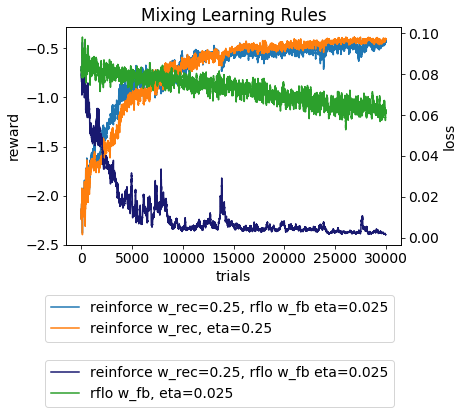

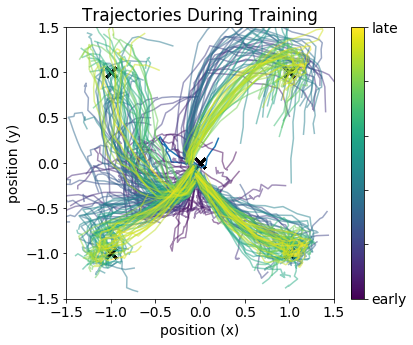

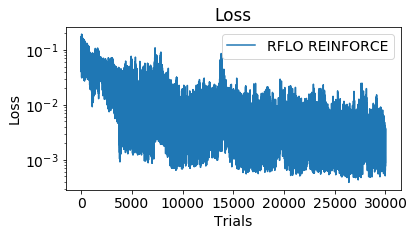

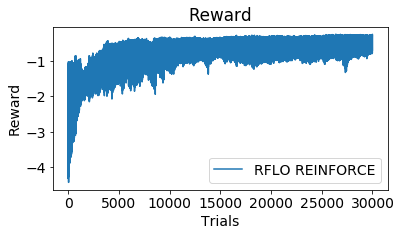

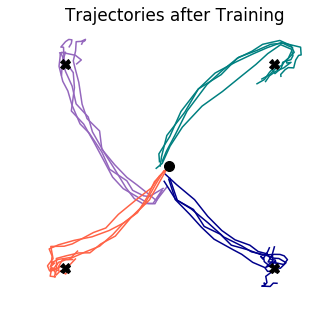

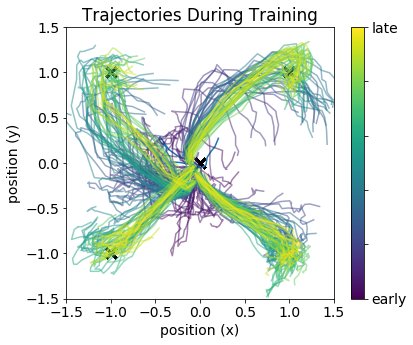

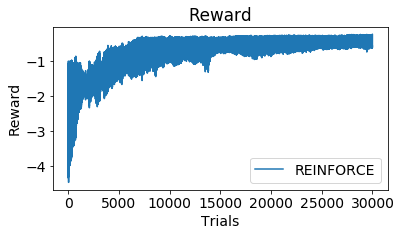

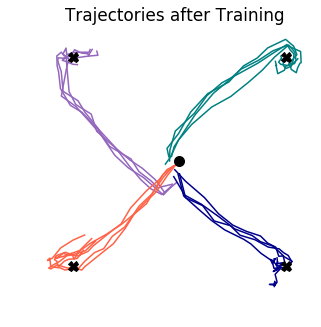

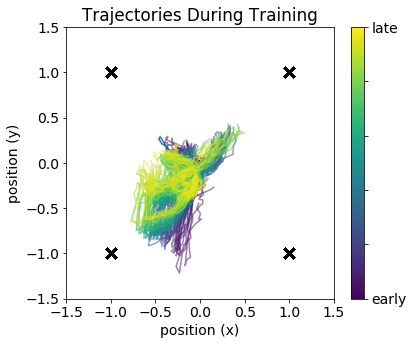

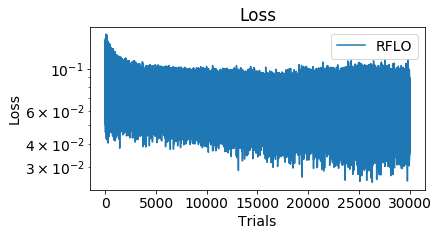

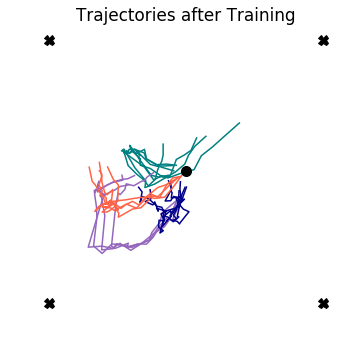

In [77]:
fig1, ax1 = plt.subplots(1,1)
ax2=ax1.twinx()


# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,eta_fb=0.025, # note difference in learning rate
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False,
               driving_feedback=True,
               rng=np.random.RandomState(0))

params.print_params()
""" Network with 2 Learning Rules"""
# Initialize RNN
net = RNN(params)

# set feedback weights to be the same as the transpose of w_out
#net.set_weights(w_fb=np.copy(net.w_m))
#print('set w_fb == w_m')


# initialize simulation
sim = Simulation(net)

rflo = RFLO(net,apply_to=['w_fb'])
reinforce = REINFORCE(net,apply_to=['w_rec'],online=False,tau_reward=5)
rflo.print_params()
reinforce.print_params()
sim.run_session(n_trials=30000, tasks=[task1,task2,task3,task4], learn_alg=[rflo,reinforce], probe_types=['loss','reward'], plot=True, plot_freq=100)

fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])



""" Control 1 """
net_ctrl1 = RNN(params)

# set feedback weights to be the same as the transpose of w_out
#net_ctrl.set_weights(w_fb=np.copy(net.w_m))
#print('set w_fb == w_m')


# initialize simulation
sim_ctrl1 = Simulation(net_ctrl1)

reinforce = REINFORCE(net_ctrl1,apply_to=['w_rec'],online=False,tau_reward=5)
reinforce.print_params()
sim_ctrl1.run_session(n_trials=30000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['reward'], plot=True, plot_freq=100)

fig = plot_trained_trajectories(sim=sim_ctrl1, tasks=[task1,task2,task3,task4])

""" Control 2 """
net_ctrl2 = RNN(params)

# set feedback weights to be the same as the transpose of w_out
#net_ctrl.set_weights(w_fb=np.copy(net.w_m))
#print('set w_fb == w_m')


# initialize simulation
sim_ctrl2 = Simulation(net_ctrl2)

rflo = RFLO(net_ctrl2,apply_to=['w_fb'],online=False)
rflo.print_params()
sim_ctrl2.run_session(n_trials=30000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=100)

fig = plot_trained_trajectories(sim=sim_ctrl2, tasks=[task1,task2,task3,task4])


""" Plot Loss with moving average for comparison across sweep """
reward = uniform_filter1d(np.mean(sim.session_probes['reward'],axis=1),50)
loss = uniform_filter1d(np.mean(sim.session_probes['loss'],axis=1),50)
av_ctrl1 = uniform_filter1d(np.mean(sim_ctrl1.session_probes['reward'],axis=1),50)
av_ctrl2 = uniform_filter1d(np.mean(sim_ctrl2.session_probes['loss'],axis=1),50)

ax1.plot(reward,label='reinforce w_rec={}, rflo w_fb eta={}'.format(params.eta_rec,params.eta_fb),color='C0')
ax2.plot(loss,label='reinforce w_rec={}, rflo w_fb eta={}'.format(params.eta_rec,params.eta_fb),color='midnightblue')
ax1.plot(av_ctrl1,label='reinforce w_rec, eta={}'.format(params.eta_rec),color='C1')
ax2.plot(av_ctrl2,label='rflo w_fb, eta={}'.format(params.eta_fb),color='C2')

ax1.set_xlabel('trials')
ax1.set_ylabel('reward')
ax2.set_ylabel('loss')
ax1.set_title('Mixing Learning Rules')
ax1.legend(bbox_to_anchor=(1,-.2))
ax2.legend(bbox_to_anchor=(1,-.5))
plt.tight_layout()
plt.show()


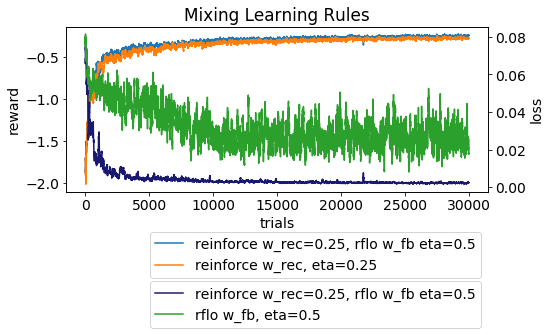

In [69]:
fig1, ax1 = plt.subplots(1,1,figsize=(8,6))
ax2=ax1.twinx()
ax1.plot(reward,label='reinforce w_rec={}, rflo w_fb eta={}'.format(params.eta_rec,params.eta_fb),color='C0')
ax2.plot(loss,label='reinforce w_rec={}, rflo w_fb eta={}'.format(params.eta_rec,params.eta_fb),color='midnightblue')
ax1.plot(av_ctrl1,label='reinforce w_rec, eta={}'.format(params.eta_rec),color='C1')
ax2.plot(av_ctrl2,label='rflo w_fb, eta={}'.format(params.eta_fb),color='C2')

ax1.set_xlabel('trials')
ax1.set_ylabel('reward')
ax2.set_ylabel('loss')
ax1.set_title('Mixing Learning Rules')
ax1.legend(bbox_to_anchor=(1,-.2))
ax2.legend(bbox_to_anchor=(1,-.5))
plt.tight_layout()
plt.show()

In [78]:
""" alignment of w_fb with w_out """
from utils.metric import cos_sim

similarity = cos_sim(net.w_fb.T.ravel(),net.w_out.ravel())
similarity_ctrl1 = cos_sim(net_ctrl1.w_fb.T.ravel(),net_ctrl1.w_out.ravel())
similarity_ctrl2 = cos_sim(net_ctrl2.w_fb.T.ravel(),net_ctrl2.w_out.ravel())
print('net alignment w_fb w_out = {:.3f}'.format(similarity))
print('net (ctrl1) alignment w_fb w_out = {:.3f}'.format(similarity_ctrl1))
print('net (ctrl2) alignment w_fb w_out = {:.3f}'.format(similarity_ctrl2))

net alignment w_fb w_out = 0.517
net (ctrl1) alignment w_fb w_out = 0.058
net (ctrl2) alignment w_fb w_out = -0.032


In [79]:
params.print_params()

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.25
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: True
eta_fb: 0.025
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
sig_rec_dim: None
rng: <mtrand.RandomState object at 0x7fea4fde28b8>


# COPY

23it [00:00, 227.87it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.25
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: True
eta_fb: 0.5
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
sig_rec_dim: None
rng: <mtrand.RandomState object at 0x7fea3c525ab0>
apply_to :  ['w_fb']
online :  True
weight_transport :  True
apply_to :  ['w_rec']
online :  False


30000it [02:04, 240.16it/s]
44it [00:00, 436.25it/s]

apply_to :  ['w_rec']
online :  False


30000it [01:13, 409.85it/s]
30it [00:00, 290.24it/s]

apply_to :  ['w_fb']
online :  False
weight_transport :  True


30000it [00:59, 504.76it/s]


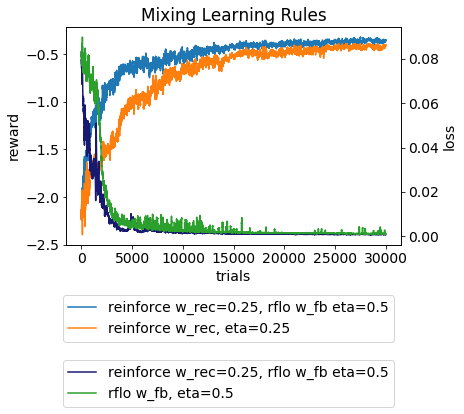

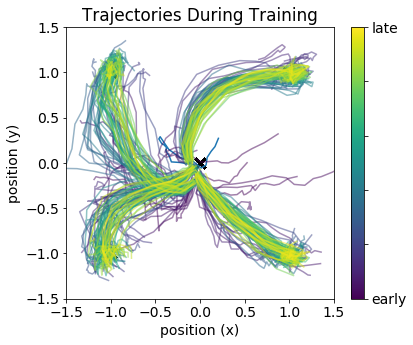

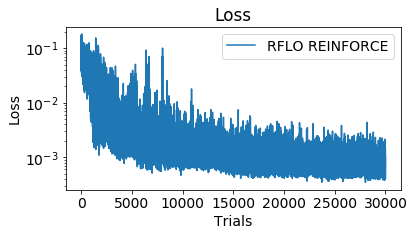

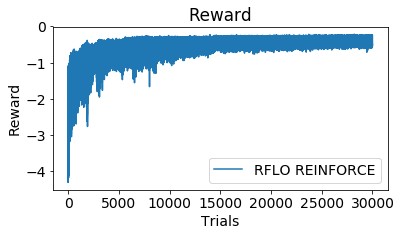

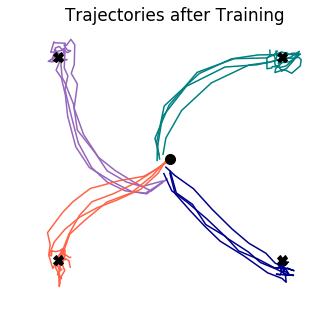

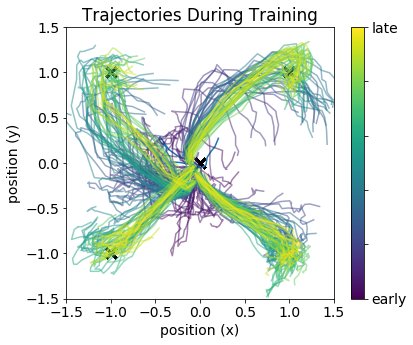

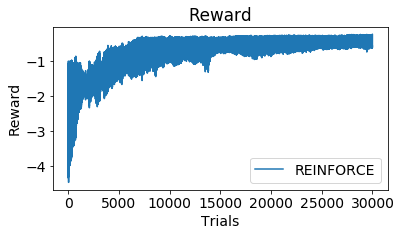

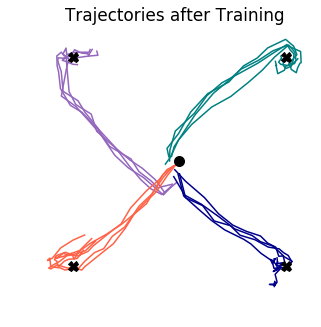

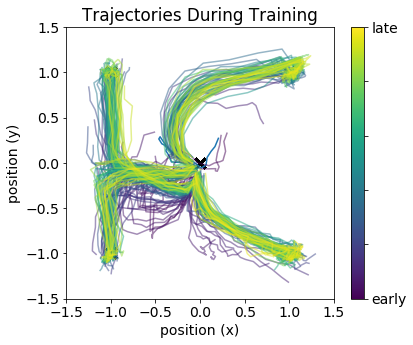

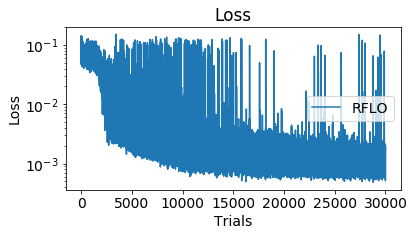

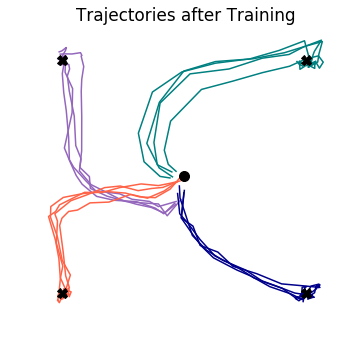

In [75]:
fig1, ax1 = plt.subplots(1,1)
ax2=ax1.twinx()


# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,eta_fb=0.5, # note difference in learning rate
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False,
               driving_feedback=True,
               rng=np.random.RandomState(0))

params.print_params()
""" Network with 2 Learning Rules"""
# Initialize RNN
net = RNN(params)

# set feedback weights to be the same as the transpose of w_out
#net.set_weights(w_fb=np.copy(net.w_m))
#print('set w_fb == w_m')


# initialize simulation
sim = Simulation(net)

rflo = RFLO(net,apply_to=['w_fb'])
reinforce = REINFORCE(net,apply_to=['w_rec'],online=False,tau_reward=5)
rflo.print_params()
reinforce.print_params()
sim.run_session(n_trials=30000, tasks=[task1,task2,task3,task4], learn_alg=[rflo,reinforce], probe_types=['loss','reward'], plot=True, plot_freq=100)

fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])



""" Control 1 """
net_ctrl1 = RNN(params)

# set feedback weights to be the same as the transpose of w_out
#net_ctrl.set_weights(w_fb=np.copy(net.w_m))
#print('set w_fb == w_m')


# initialize simulation
sim_ctrl1 = Simulation(net_ctrl1)

reinforce = REINFORCE(net_ctrl1,apply_to=['w_rec'],online=False,tau_reward=5)
reinforce.print_params()
sim_ctrl1.run_session(n_trials=30000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['reward'], plot=True, plot_freq=100)

fig = plot_trained_trajectories(sim=sim_ctrl1, tasks=[task1,task2,task3,task4])

""" Control 2 """
net_ctrl2 = RNN(params)

# set feedback weights to be the same as the transpose of w_out
#net_ctrl.set_weights(w_fb=np.copy(net.w_m))
#print('set w_fb == w_m')


# initialize simulation
sim_ctrl2 = Simulation(net_ctrl2)

rflo = RFLO(net_ctrl2,apply_to=['w_fb'],online=False)
rflo.print_params()
sim_ctrl2.run_session(n_trials=30000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=100)

fig = plot_trained_trajectories(sim=sim_ctrl2, tasks=[task1,task2,task3,task4])


""" Plot Loss with moving average for comparison across sweep """
reward = uniform_filter1d(np.mean(sim.session_probes['reward'],axis=1),50)
loss = uniform_filter1d(np.mean(sim.session_probes['loss'],axis=1),50)
av_ctrl1 = uniform_filter1d(np.mean(sim_ctrl1.session_probes['reward'],axis=1),50)
av_ctrl2 = uniform_filter1d(np.mean(sim_ctrl2.session_probes['loss'],axis=1),50)

ax1.plot(reward,label='reinforce w_rec={}, rflo w_fb eta={}'.format(params.eta_rec,params.eta_fb),color='C0')
ax2.plot(loss,label='reinforce w_rec={}, rflo w_fb eta={}'.format(params.eta_rec,params.eta_fb),color='midnightblue')
ax1.plot(av_ctrl1,label='reinforce w_rec, eta={}'.format(params.eta_rec),color='C1')
ax2.plot(av_ctrl2,label='rflo w_fb, eta={}'.format(params.eta_fb),color='C2')

ax1.set_xlabel('trials')
ax1.set_ylabel('reward')
ax2.set_ylabel('loss')
ax1.set_title('Mixing Learning Rules')
ax1.legend(bbox_to_anchor=(1,-.2))
ax2.legend(bbox_to_anchor=(1,-.5))
plt.tight_layout()
plt.show()


In [76]:
""" alignment of w_fb with w_out """
from utils.metric import cos_sim

similarity = cos_sim(net.w_fb.T.ravel(),net.w_out.ravel())
similarity_ctrl1 = cos_sim(net_ctrl1.w_fb.T.ravel(),net_ctrl1.w_out.ravel())
similarity_ctrl2 = cos_sim(net_ctrl2.w_fb.T.ravel(),net_ctrl2.w_out.ravel())
print('net alignment w_fb w_out = {:.3f}'.format(similarity))
print('net (ctrl1) alignment w_fb w_out = {:.3f}'.format(similarity_ctrl1))
print('net (ctrl2) alignment w_fb w_out = {:.3f}'.format(similarity_ctrl2))

net alignment w_fb w_out = 0.309
net (ctrl1) alignment w_fb w_out = 0.058
net (ctrl2) alignment w_fb w_out = 0.205
